In [33]:
import xarray as xr
import flox.xarray as fx
import numpy as np
import pandas as pd
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import calendar

In [2]:
ds_globe = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/new_test.nc', chunks={'N_PROF':10000})

In [5]:
unique_prof = np.arange(len(ds_globe['N_PROF']))
ds_globe = ds_globe.assign_coords(N_PROF=('N_PROF', unique_prof))
ds_so = ds_globe.where(ds_globe.LATITUDE.compute()<-30, drop=True)

In [6]:
def get_ds_binned(ds, lon_bins, lat_bins):
    """
    Bin an xarray Dataset by 3-degree latitude and longitude bins,
    replacing Interval dimensions with bin centers.
    
    Parameters:
        ds : xarray.Dataset
            The dataset to bin.
        lon_bins : array-like
            Bin edges for longitude (e.g. np.arange(-180, 181, 3))
        lat_bins : array-like
            Bin edges for latitude (e.g. np.arange(-90, 91, 3))
    
    Returns:
        xarray.Dataset
            Binned dataset with dimensions (PRES_INTERPOLATED, lon_c, lat_c)
    """

    # Step 1: Bin with fx.xarray_reduce using IntervalIndex
    ds_binned = fx.xarray_reduce(
        ds,
        'LONGITUDE',
        'LATITUDE',
        func='mean',
        expected_groups=(
            pd.IntervalIndex.from_breaks(lon_bins),
            pd.IntervalIndex.from_breaks(lat_bins),
        ),
        fill_value=np.nan,
        skipna=True
    )

    # Step 2: Create left, right, center arrays
    lon_l = np.array(lon_bins[:-1])
    lon_r = np.array(lon_bins[1:])
    lon_c = (lon_l + lon_r) / 2

    lat_l = np.array(lat_bins[:-1])
    lat_r = np.array(lat_bins[1:])
    lat_c = (lat_l + lat_r) / 2

    # Step 3: Replace Interval dims with center dims
    ds_binned = ds_binned.assign_coords({
        "lon_c": ("LONGITUDE", [iv.mid for iv in ds_binned['LONGITUDE'].values]),
        "lat_c": ("LATITUDE", [iv.mid for iv in ds_binned['LATITUDE'].values]),
        "lon_l": ("LONGITUDE", lon_l),
        "lon_r": ("LONGITUDE", lon_r),
        "lat_l": ("LATITUDE", lat_l),
        "lat_r": ("LATITUDE", lat_r),
    })

    ds_binned = ds_binned.swap_dims({"LONGITUDE": "lon_c", "LATITUDE": "lat_c"})

    return ds_binned

In [26]:
ds_so_binned = get_ds_binned(ds_so, lon_bins, so_lat_bins)

In [27]:
depth = 10
ds_so_binned_depth = ds_so_binned.sel(PRES_INTERPOLATED=depth, method='nearest')[['SA', 'CT', 'SIG0']].compute()

In [48]:
lon_bins = np.arange(-180,181,3)
so_lat_bins = np.arange(-90,-29,3)


array([-180, -177, -174, -171, -168, -165, -162, -159, -156, -153, -150,
       -147, -144, -141, -138, -135, -132, -129, -126, -123, -120, -117,
       -114, -111, -108, -105, -102,  -99,  -96,  -93,  -90,  -87,  -84,
        -81,  -78,  -75,  -72,  -69,  -66,  -63,  -60,  -57,  -54,  -51,
        -48,  -45,  -42,  -39,  -36,  -33,  -30,  -27,  -24,  -21,  -18,
        -15,  -12,   -9,   -6,   -3,    0,    3,    6,    9,   12,   15,
         18,   21,   24,   27,   30,   33,   36,   39,   42,   45,   48,
         51,   54,   57,   60,   63,   66,   69,   72,   75,   78,   81,
         84,   87,   90,   93,   96,   99,  102,  105,  108,  111,  114,
        117,  120,  123,  126,  129,  132,  135,  138,  141,  144,  147,
        150,  153,  156,  159,  162,  165,  168,  171,  174,  177,  180])

In [12]:
monthly_groups = ds_so.groupby('TIME.month')

ds_so_binned_monthly = {
    calendar.month_abbr[month]: get_ds_binned(group, lon_bins, so_lat_bins)
    for month, group in monthly_groups
}

In [19]:
%%time

depth = 10
given_depth_monthly = {
    season: ds.sel(PRES_INTERPOLATED=depth, method='nearest')[['SA', 'CT', 'SIG0']].compute()
    for season, ds in ds_so_binned_monthly.items()
}

CPU times: user 13min 34s, sys: 11min 21s, total: 24min 55s
Wall time: 7min 54s


In [28]:
monthly_CT_anomalies = {
    month: ds.CT - ds_so_binned_depth.CT
    for month, ds in given_depth_monthly.items()
}

/tmp/ipykernel_64745/3211133685.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


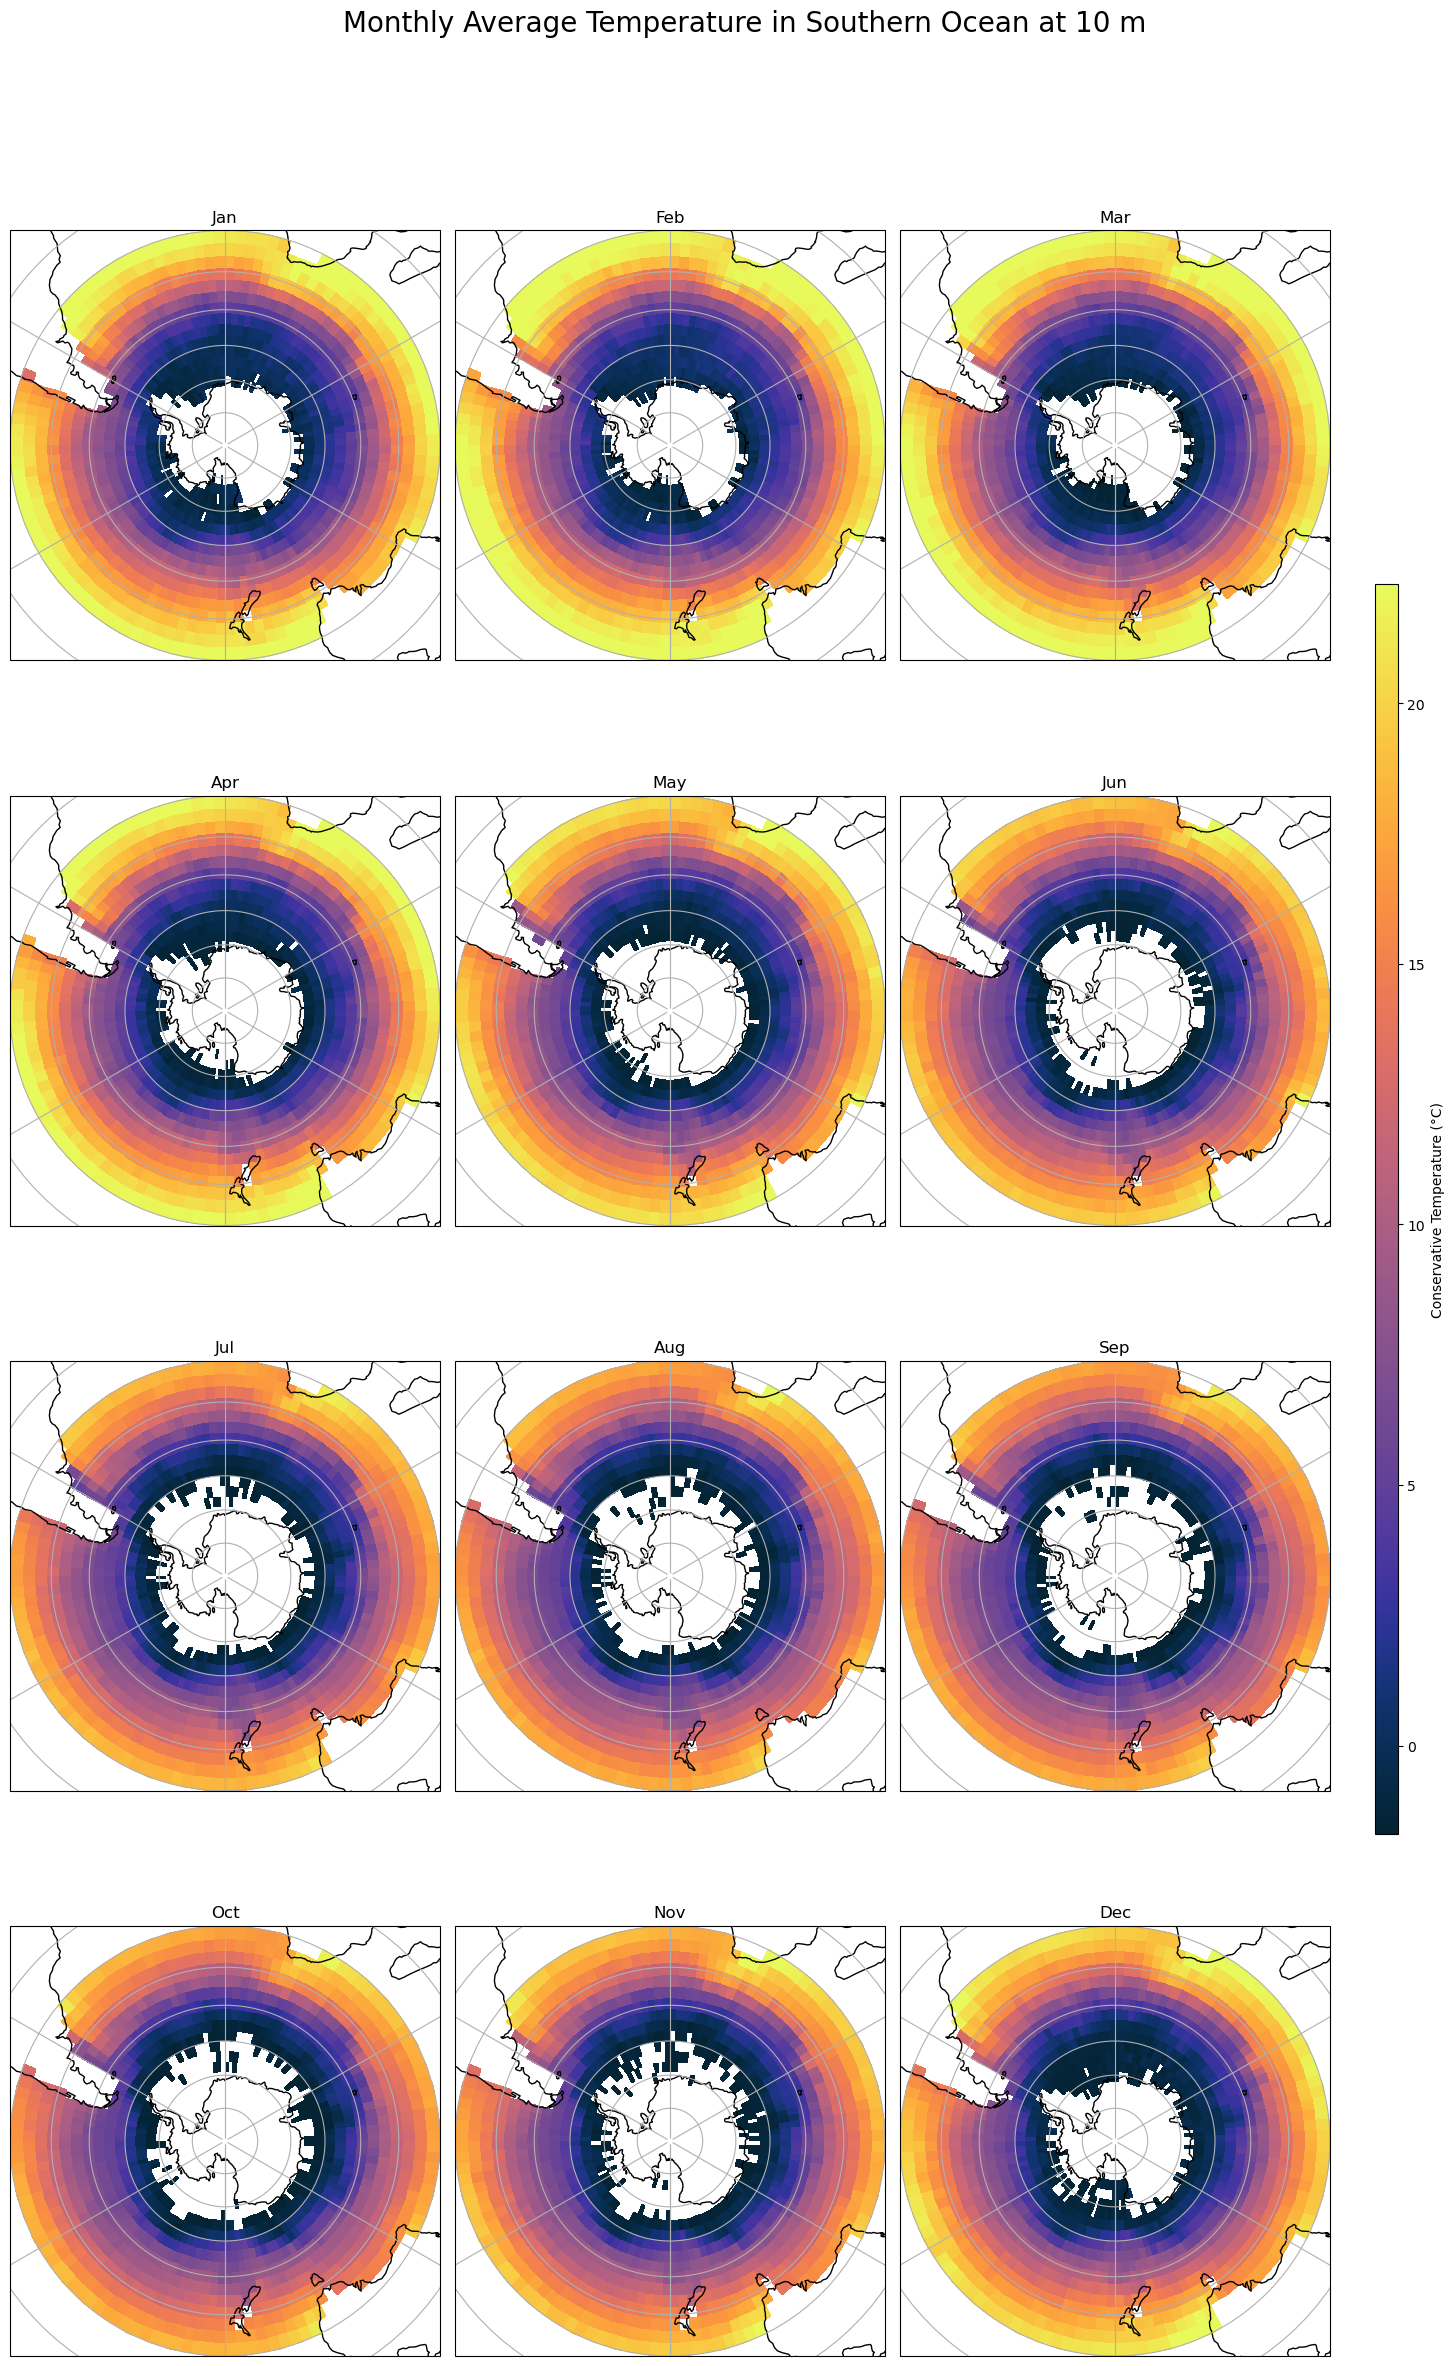

In [23]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create figure and subplots
fig, axs = plt.subplots(4, 3, figsize=(15, 25), 
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs = axs.ravel()

# Define consistent vmin/vmax based on percentiles across all months
all_ct = xr.concat([given_depth_monthly[m].CT for m in month_order], dim='month')
vmin = float(all_ct.quantile(0.02))
vmax = float(all_ct.quantile(0.98))

# Plot each month
for i, month in enumerate(month_order):
    ds = given_depth_monthly[month]
    ax = axs[i]
    ax.coastlines()
    ax.gridlines(draw_labels=False)
    ds.CT.plot(
        ax=ax,
        x='lon_c',
        y='lat_c',
        transform=ccrs.PlateCarree(),
        cmap=cmo.thermal,
        vmin=vmin,
        vmax=vmax,
        add_colorbar=False
    )
    ax.set_title(month)

# Shared colorbar
cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
plt.colorbar(axs[0].collections[0], cax=cbar_ax, label="Conservative Temperature (°C)")

plt.suptitle('Monthly Average Temperature in Southern Ocean at 10 m', fontsize=20)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

/tmp/ipykernel_64745/199604856.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


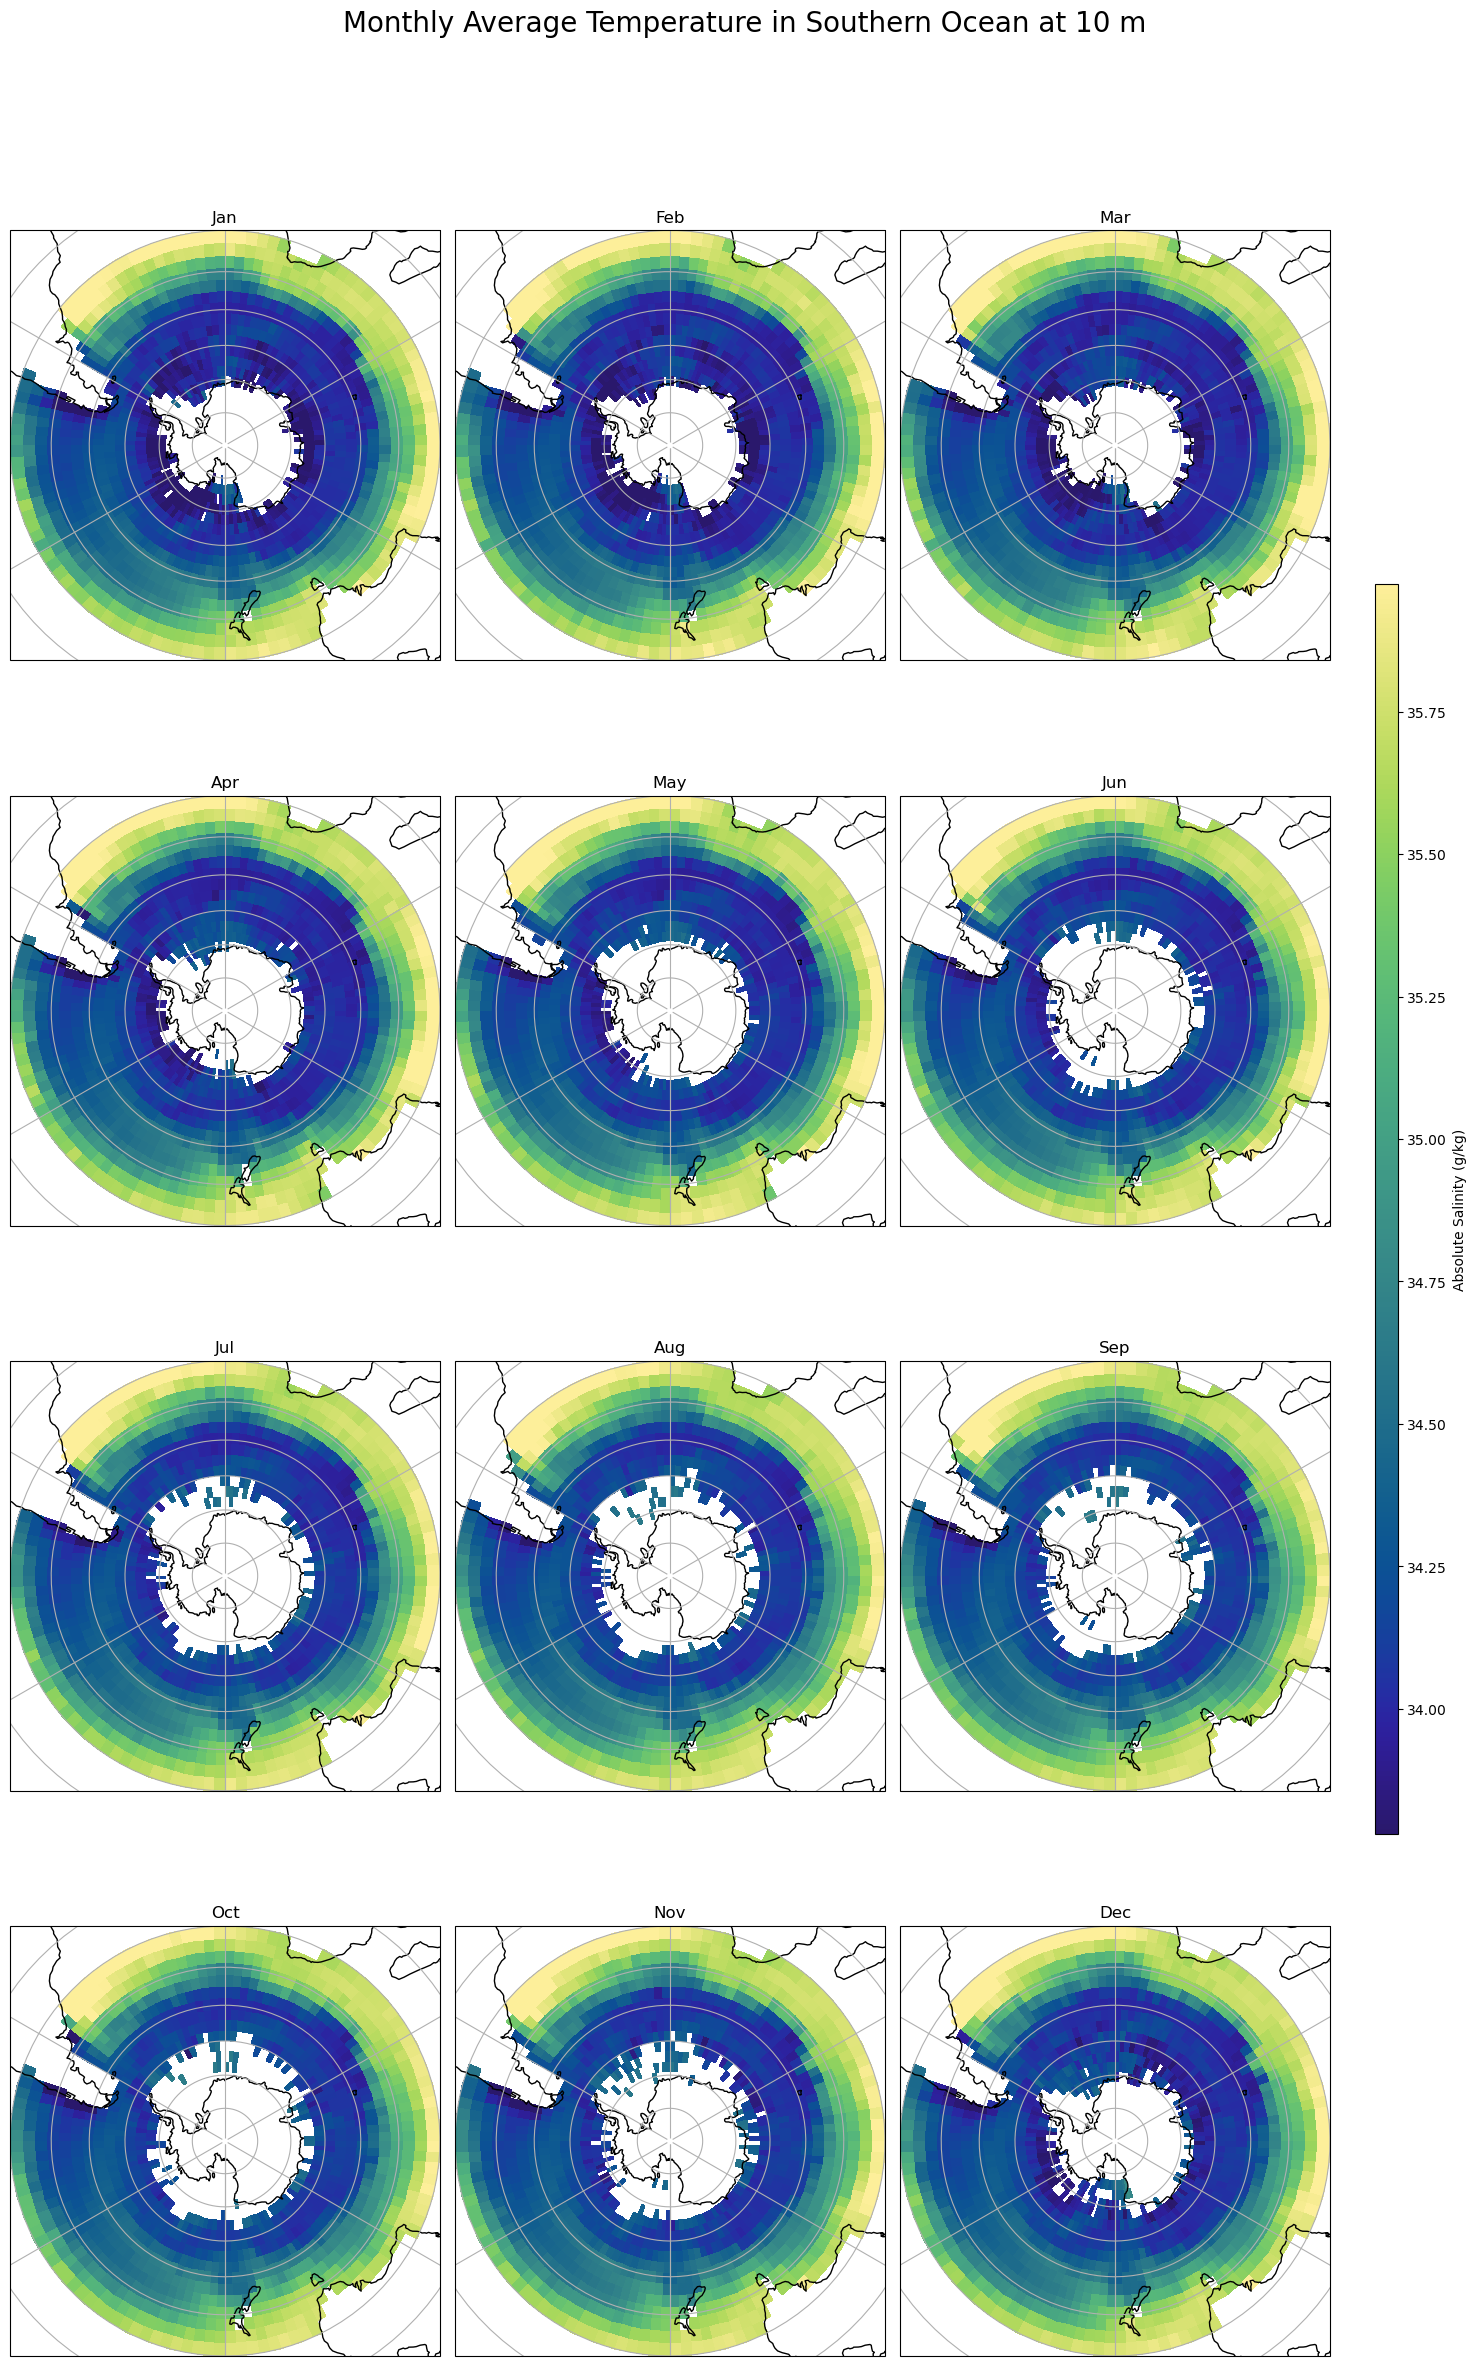

In [34]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create figure and subplots
fig, axs = plt.subplots(4, 3, figsize=(15, 25), 
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs = axs.ravel()

# Define consistent vmin/vmax based on percentiles across all months
all_sa = xr.concat([given_depth_monthly[m].SA for m in month_order], dim='month')
vmin = float(all_sa.quantile(0.02))
vmax = float(all_sa.quantile(0.98))

# Plot each month
for i, month in enumerate(month_order):
    ds = given_depth_monthly[month]
    ax = axs[i]
    ax.coastlines()
    ax.gridlines(draw_labels=False)
    ds.SA.plot(
        ax=ax,
        x='lon_c',
        y='lat_c',
        transform=ccrs.PlateCarree(),
        cmap=cmo.haline,
        vmin=vmin,
        vmax=vmax,
        add_colorbar=False
    )
    ax.set_title(month)

# Shared colorbar
cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
plt.colorbar(axs[0].collections[0], cax=cbar_ax, label="Absolute Salinity (g/kg)")

plt.suptitle('Monthly Average Temperature in Southern Ocean at 10 m', fontsize=20)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

/tmp/ipykernel_64745/758539370.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


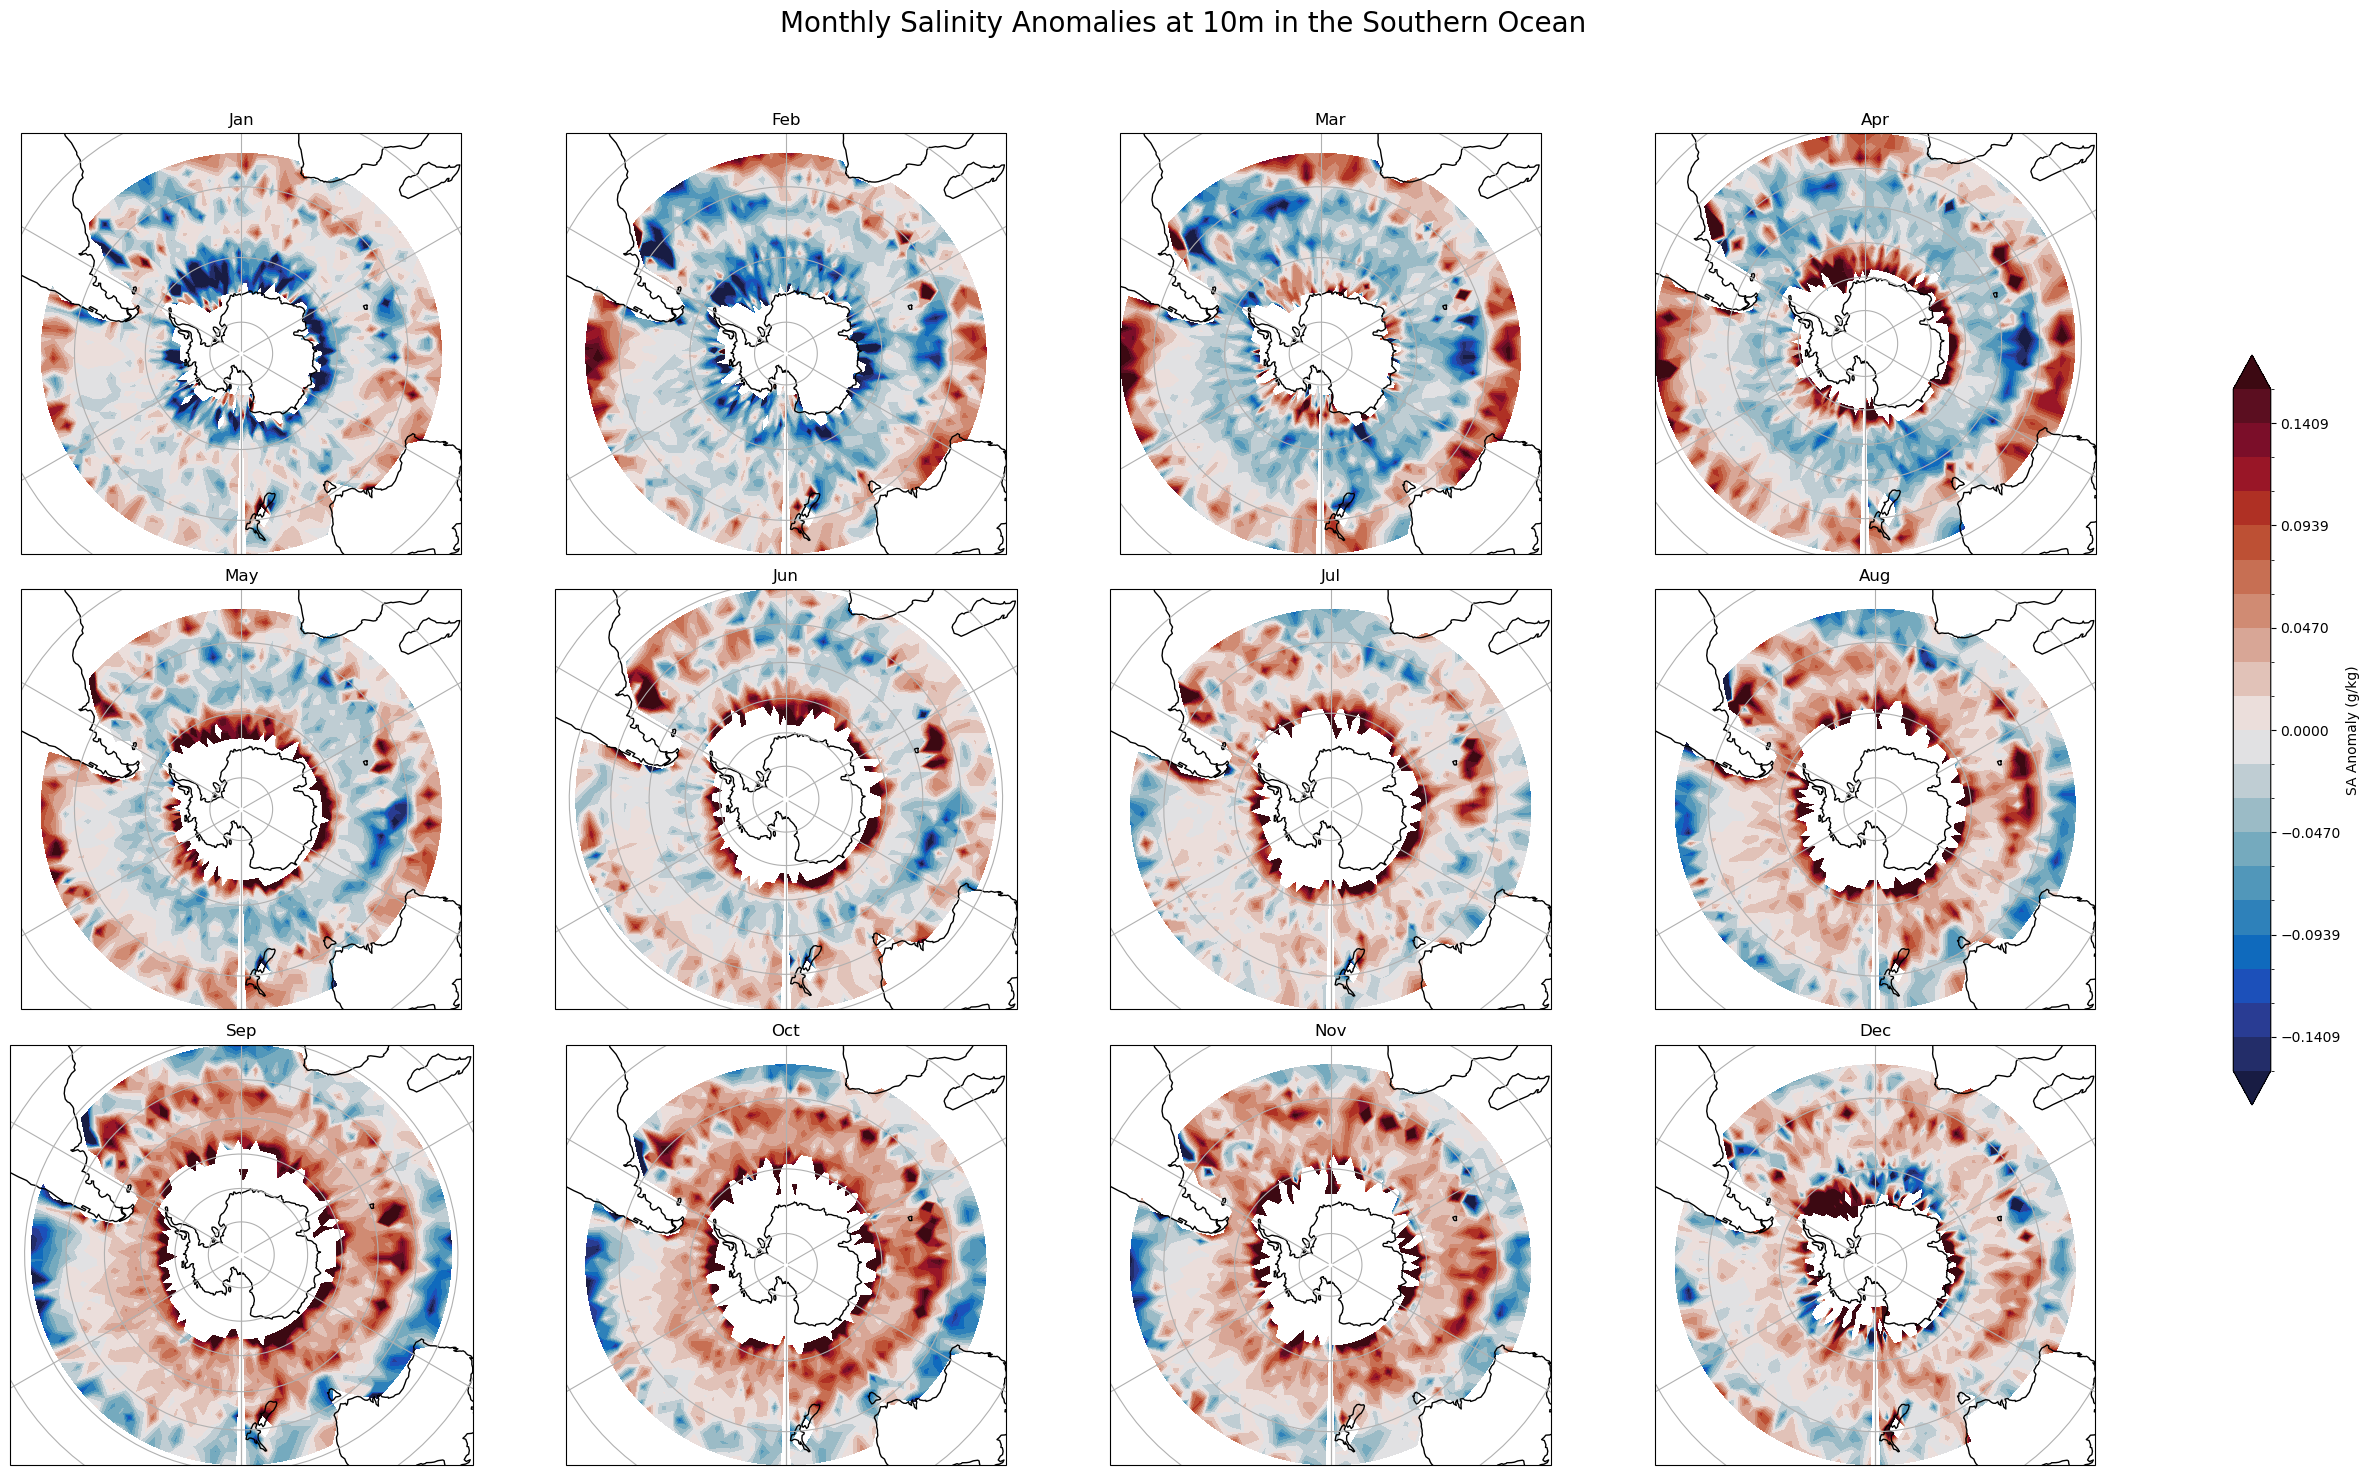

In [50]:
# Define month order
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Compute SA anomalies
monthly_SA_anomalies = {
    month: given_depth_monthly[month].SA - ds_so_binned_depth.SA
    for month in month_order
}

# Determine symmetric color range
all_anom = xr.concat([monthly_SA_anomalies[m] for m in month_order], dim='month')
vmin_raw = float(all_anom.quantile(0.05))
vmax_raw = float(all_anom.quantile(0.95))
absmax = max(abs(vmin_raw), abs(vmax_raw))
vmin, vmax = -absmax, absmax

# Plot
fig, axs = plt.subplots(3, 4, figsize=(25, 15), 
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs = axs.ravel()

# Store the first plot's result for colorbar
contourf_obj = None

for i, month in enumerate(month_order):
    da = monthly_SA_anomalies[month]
    ax = axs[i]
    ax.coastlines()
    ax.gridlines(draw_labels=False)
    
    contour = da.plot.contourf(
        ax=ax,
        x='lon_c',
        y='lat_c',
        transform=ccrs.PlateCarree(),
        cmap=cmo.balance,
        levels=np.linspace(vmin, vmax, 21),
        extend='both',
        add_colorbar=False
    )
    if contourf_obj is None:
        contourf_obj = contour  # Save for colorbar

    ax.set_title(f"{month}")

# Shared colorbar using the contour object
cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
plt.colorbar(contourf_obj, cax=cbar_ax, label="SA Anomaly (g/kg)")

plt.suptitle("Monthly Salinity Anomalies at 10m in the Southern Ocean", fontsize=20)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

